# Loading the File Into Python and Importing Libraries

In [1]:
path_to_pdf = r"C:\Users\dane.parks\PycharmProjects\civilpy\Notebooks\res\temp\Enola_Structure_QC.pdf"
path_to_original_pdf = r"C:\Users\dane.parks\PycharmProjects\civilpy\Notebooks\res\temp\Locked Manual.pdf"

In [2]:
import os
import fitz
import copy
from pathlib import Path

# Uncomment and delete next cell after update pushes
# from civilpy.CLI import bcolors

doc = fitz.open(path_to_pdf) # open a document

# General Document Checks

In [3]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [4]:
def check_bookmarks(toc):
    all_bookmarks = [*range(len(doc))[1:], len(doc)]
    bookmark_parent_sections = []
    print(f"Checking {len(doc)} Bookmarks...")
    
    # Check that there is only 1 bookmark to each sheet
    for index, bookmark in enumerate(toc):
        if bookmark[2] == -1:
            bookmark_parent_sections.append(bookmark[1])
        elif not all_bookmarks:
            print(f"{bcolors.WARNING}Duplicate bookmark: {bookmark}{bcolors.ENDC}")
        else:
            try:
                all_bookmarks.remove(bookmark[2])
            except Exception as e:
                print(f"\n{bcolors.FAIL}Multiple Bookmarks are pointing to the same page: \n{bookmark[1], index, e}{bcolors.ENDC}")
                return all_bookmarks
    
    print(f"\nFound {len(bookmark_parent_sections)} sections of the document: ")
    print([f"{x}" for x in bookmark_parent_sections])
    
    # Return the Parent Sections of the PDF document
    return all_bookmarks, bookmark_parent_sections

## MetaData

In [5]:
def check_metadata_for_title(doc):
    if doc.metadata['title'] == '':
        print(f"\n{bcolors.WARNING}Document has no Title in metadata{bcolors.ENDC}")
    else:
        pass

## Annotations

In [6]:
# Function to get annotations out of a page as a list
def get_and_verify_annotations(page=None):
    annotations = []

    for annot in page.annots():  # Loop through the annotations on the page
        annotations.append(annot)

    return annotations

### Decoding Annotations

There are two types of annotations, "Parent" annotations are the original comments, "Children" are the support / follow up information available as an associated attribute. So when someone updates the status of a markup or creates a reply to an annotation, that would be considered a "child" element to the original "parent" comment.

In [7]:
page = doc[2]
list_of_annotations = get_and_verify_annotations(page)
list_of_annotations[1]

'Polygon' annotation on page 2 of C:\Users\dane.parks\PycharmProjects\civilpy\Notebooks\res\temp\Enola_Structure_QC.pdf

### Figuring out how Annotations are related to each other

Annotation 64 is a response to Annotation 8. 

In [8]:
# Annotation 8 - "parent_annotations"
print(list_of_annotations[8].info['subject'])
print(list_of_annotations[8].info['content'])
print(f"By: {list_of_annotations[8].info['title']} on {list_of_annotations[8].info['modDate'][2:6]}-{list_of_annotations[8].info['modDate'][6:8]}-{list_of_annotations[8].info['modDate'][8:10]} at {list_of_annotations[8].info['modDate'][10:12]}:{list_of_annotations[8].info['modDate'][12:14]}")
print(f"ID: {list_of_annotations[8].info['id']}")
print(f"XREF: {list_of_annotations[8].xref}")

# Annotation 64 - "Not sure what this refers to. Will defer to track team. Current MVC spreadsheet and calcs show Track D location controlling for MVC, as shown in plan."
print(f"\n{list_of_annotations[64].info['subject']}")
print(list_of_annotations[64].info['content'])
print(f"By: {list_of_annotations[64].info['title']} on {list_of_annotations[64].info['modDate'][2:6]}-{list_of_annotations[64].info['modDate'][6:8]}-{list_of_annotations[64].info['modDate'][8:10]} at {list_of_annotations[64].info['modDate'][10:12]}:{list_of_annotations[64].info['modDate'][12:14]}")
print(f"In Regard to comment {list_of_annotations[64].irt_xref}")

Cloud+
G TRACK CONTROLS- PROFILE NEEDS TO BE DROPPED
By: MBI - L. Hoekenga on 2023-09-29 at 09:19
ID: PAPGGOVOOOVGZYBI
XREF: 1040

Re: Reviewer Cloud+ Comment
Not sure what this refers to. Will defer to track team. Current MVC spreadsheet and calcs show Track D location controlling for MVC, as shown in plan.
By: kevin.mcging on 2023-10-01 at 18:11
In Regard to comment 1040


Annotation 25 is a "Status Update" Annotation - These seem to be "Text" type Annotations;

In [9]:
print(list_of_annotations[25].info['subject'])
print(list_of_annotations[25].info['content'])

Set to 1. Requires Attention



There are four types of annotations on the page, three of them contain text content: status updates, responses, and original comments,

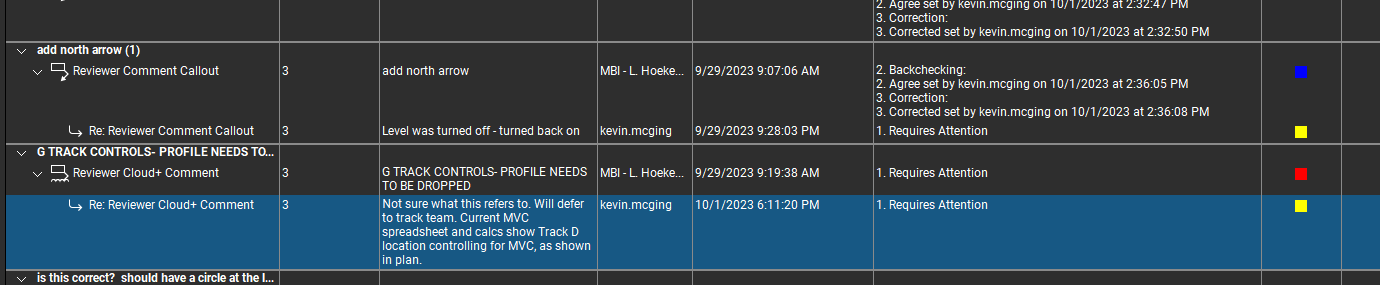

Some markups are `orphan_markups` meaning there's no actual words, an example would be either circling an object or crossing out a value annotation, we should probably stop crossing out things.

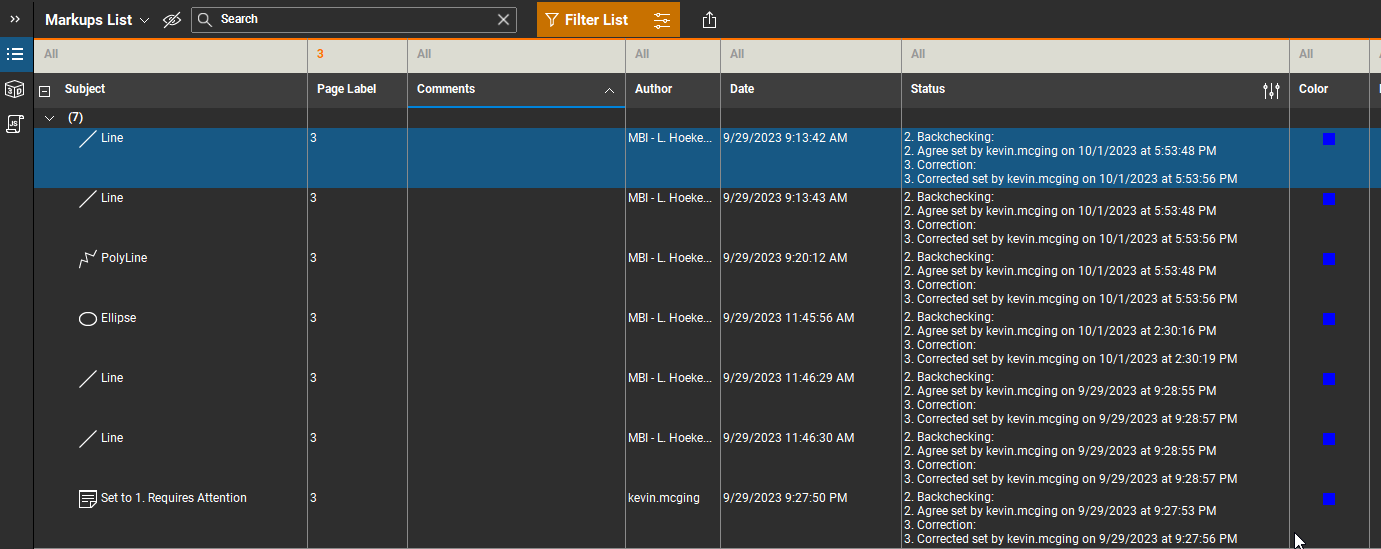

In [10]:
# Define the holding lists for the four types of annotations we use
status_update_annotations = []
response_annotations = []
parent_annotations = []
associated_empties = []


# Check if the annotation is a status update or, a response to an earlier comment
for i in range(0, len(list_of_annotations)):
    if str(list_of_annotations[i])[:6] == "'Text'" and list_of_annotations[i].info['subject'][:3] != 'Re:':
        print(f"{i} - status_update")
        status_update_annotations.append((i, list_of_annotations[i]))
    elif str(list_of_annotations[i])[:6] == "'Text'" and list_of_annotations[i].info['subject'][:3] == 'Re:':
        print(f"{i} - response_annotation")
        response_annotations.append((i, list_of_annotations[i]))
    elif list_of_annotations[i].irt_xref == 0:
        print(f"{i} - parent_annotation")
        parent_annotations.append((i, list_of_annotations[i]))
    else:
        print(f"{i} - associated_empty")
        associated_empties.append((i, list_of_annotations[i]))

0 - parent_annotation
1 - associated_empty
2 - parent_annotation
3 - associated_empty
4 - parent_annotation
5 - associated_empty
6 - parent_annotation
7 - associated_empty
8 - parent_annotation
9 - parent_annotation
10 - parent_annotation
11 - parent_annotation
12 - parent_annotation
13 - associated_empty
14 - parent_annotation
15 - associated_empty
16 - parent_annotation
17 - parent_annotation
18 - associated_empty
19 - parent_annotation
20 - parent_annotation
21 - parent_annotation
22 - parent_annotation
23 - associated_empty
24 - parent_annotation
25 - status_update
26 - status_update
27 - status_update
28 - response_annotation
29 - status_update
30 - status_update
31 - status_update
32 - status_update
33 - status_update
34 - status_update
35 - status_update
36 - status_update
37 - status_update
38 - status_update
39 - response_annotation
40 - status_update
41 - status_update
42 - status_update
43 - response_annotation
44 - status_update
45 - status_update
46 - status_update
47 - st

In [11]:
# Sorting annotations that contain no text into their own lists
parent_comments = []
empty_parent = []

for response in parent_annotations:
    # If the markup has no comment, move it to orphan comments
    if response[1].info['content'] == '':
        empty_parent.append(response)
    else: 
        parent_comments.append(response)

print("Comments:")
# Really annoying, have to escape / and \ characters in the strings, so encode then decode does that
print(*[x[1].info['content'].encode('unicode_escape').decode("utf-8") for x in parent_comments], sep='\n')
print(f"\nPlus {len(empty_parent)} additional markups without comments")

Comments:
add north arrow
LOOKING UPSTATION TRACKS D&G
THIS NEEDS TO BE FIXED.
UPDATE
G TRACK CONTROLS- PROFILE NEEDS TO BE DROPPED
T/BEAM SEAT\rELEV.
is this correct?  should have a circle at the location.  What is 6'-0" off the centerline of track?`
why 0 7/8"?  can we make it a round inch?
what is this line?
& PR. 
WHY IS THIS SO WIDE?  I THOUGHT WE TALKED ABOUT WINGS, NOT MAKING THE SEAT THIS WIDE....

Plus 6 additional markups without comments


In [12]:
print(parent_comments[5][1].info['content'])

ELEV.M SEAT


In [13]:
parent_annotations[1][1].info['content']

'LOOKING UPSTATION TRACKS D&G'

In [14]:
# Associating Children Annotations with their parents
associated_comments = {}

# List of child comment types
children = status_update_annotations + response_annotations + associated_empties
parents = empty_parent + parent_annotations

for parent in parents:
    associated_comments[parent[0]] = []
    
    for child in children:
        if child[1].irt_xref == parent[1].xref:
            associated_comments[parent[0]].append(child)

In [15]:
# Go through the list of every value 
for key, values in associated_comments.items():
    if list_of_annotations[key].info['content'] == '':
        print("No Comment - Empty Markup")
    else:
        print(f"Comment: {list_of_annotations[key].info['content']}")
    
    for value in values:
        if value[1].info['content'] == '':
            print(f"Response: {list_of_annotations[value[0]].info['subject']}")
        else:
            print(f"Response: {list_of_annotations[value[0]].info['content']}")
    
    print("")

No Comment - Empty Markup
Response: Set to 2. Agree

No Comment - Empty Markup
Response: Set to 2. Agree

No Comment - Empty Markup
Response: Set to 2. Agree

No Comment - Empty Markup
Response: Set to 2. Agree

No Comment - Empty Markup
Response: Set to 2. Agree

No Comment - Empty Markup
Response: Set to 2. Agree

Comment: add north arrow
Response: Set to 2. Agree
Response: Level was turned off - turned back on

Comment: LOOKING UPSTATION TRACKS D&G
Response: Set to 2. Agree
Response: Reviewer Cloud+ Comment

Comment: THIS NEEDS TO BE FIXED.
Response: Set to 2. Agree
Response: Set excavation to be 40:1 from b/cap to existing abutment wall instead. Let me know if this is an improvement.
Response: Reviewer Cloud+ Comment

Comment: UPDATE
Response: Set to 2. Agree
Response: Reviewer Cloud+ Comment

Comment: G TRACK CONTROLS- PROFILE NEEDS TO BE DROPPED
Response: Not sure what this refers to. Will defer to track team. Current MVC spreadsheet and calcs show Track D location controlling fo

In [16]:
for i, annot in enumerate(list_of_annotations):
    if annot.irt_xref == 1041:
        print(i, annot)

52 'Text' annotation on page 2 of C:\Users\dane.parks\PycharmProjects\civilpy\Notebooks\res\temp\Enola_Structure_QC.pdf


In [17]:
associated_comments

{9: [(52,
   'Text' annotation on page 2 of C:\Users\dane.parks\PycharmProjects\civilpy\Notebooks\res\temp\Enola_Structure_QC.pdf)],
 10: [(53,
   'Text' annotation on page 2 of C:\Users\dane.parks\PycharmProjects\civilpy\Notebooks\res\temp\Enola_Structure_QC.pdf)],
 11: [(54,
   'Text' annotation on page 2 of C:\Users\dane.parks\PycharmProjects\civilpy\Notebooks\res\temp\Enola_Structure_QC.pdf)],
 17: [(36,
   'Text' annotation on page 2 of C:\Users\dane.parks\PycharmProjects\civilpy\Notebooks\res\temp\Enola_Structure_QC.pdf)],
 20: [(31,
   'Text' annotation on page 2 of C:\Users\dane.parks\PycharmProjects\civilpy\Notebooks\res\temp\Enola_Structure_QC.pdf)],
 21: [(32,
   'Text' annotation on page 2 of C:\Users\dane.parks\PycharmProjects\civilpy\Notebooks\res\temp\Enola_Structure_QC.pdf)],
 0: [(44,
   'Text' annotation on page 2 of C:\Users\dane.parks\PycharmProjects\civilpy\Notebooks\res\temp\Enola_Structure_QC.pdf),
  (28,
   'Text' annotation on page 2 of C:\Users\dane.parks\Pych

In [18]:
for i in range(len(empty_parent)):
    print(empty_parent[i][1].irt_xref)

0
0
0
0
0
0


In [19]:
children

[(25,
  'Text' annotation on page 2 of C:\Users\dane.parks\PycharmProjects\civilpy\Notebooks\res\temp\Enola_Structure_QC.pdf),
 (26,
  'Text' annotation on page 2 of C:\Users\dane.parks\PycharmProjects\civilpy\Notebooks\res\temp\Enola_Structure_QC.pdf),
 (27,
  'Text' annotation on page 2 of C:\Users\dane.parks\PycharmProjects\civilpy\Notebooks\res\temp\Enola_Structure_QC.pdf),
 (29,
  'Text' annotation on page 2 of C:\Users\dane.parks\PycharmProjects\civilpy\Notebooks\res\temp\Enola_Structure_QC.pdf),
 (30,
  'Text' annotation on page 2 of C:\Users\dane.parks\PycharmProjects\civilpy\Notebooks\res\temp\Enola_Structure_QC.pdf),
 (31,
  'Text' annotation on page 2 of C:\Users\dane.parks\PycharmProjects\civilpy\Notebooks\res\temp\Enola_Structure_QC.pdf),
 (32,
  'Text' annotation on page 2 of C:\Users\dane.parks\PycharmProjects\civilpy\Notebooks\res\temp\Enola_Structure_QC.pdf),
 (33,
  'Text' annotation on page 2 of C:\Users\dane.parks\PycharmProjects\civilpy\Notebooks\res\temp\Enola_Str

In [20]:
# Check if child annotation matches the parent (Top level annotation if it does)
for i in range(0, len(list_of_annotations)):
    print(f"\nAnnotation {i}")
    print(f"{list_of_annotations[i].info['content']}")
    print(f"{list_of_annotations[i].info['subject']}")
    if list_of_annotations[i].parent.first_annot.info['id'] == list_of_annotations[i].info['id']:
        print("Top level annotation")
    else:
        print(f"Child to {list_of_annotations[i].parent.first_annot.info['id']}")


Annotation 0
add north arrow
Reviewer Comment Callout
Top level annotation

Annotation 1

Reviewer Cloud+ Comment
Child to DTPLXPRDFJUJLIPS

Annotation 2
LOOKING UPSTATION TRACKS D&G
Cloud+
Child to DTPLXPRDFJUJLIPS

Annotation 3

Reviewer Cloud+ Comment
Child to DTPLXPRDFJUJLIPS

Annotation 4
THIS NEEDS TO BE FIXED.
Cloud+
Child to DTPLXPRDFJUJLIPS

Annotation 5

Reviewer Cloud+ Comment
Child to DTPLXPRDFJUJLIPS

Annotation 6
UPDATE
Cloud+
Child to DTPLXPRDFJUJLIPS

Annotation 7

Reviewer Cloud+ Comment
Child to DTPLXPRDFJUJLIPS

Annotation 8
G TRACK CONTROLS- PROFILE NEEDS TO BE DROPPED
Cloud+
Child to DTPLXPRDFJUJLIPS

Annotation 9

Line
Child to DTPLXPRDFJUJLIPS

Annotation 10

Line
Child to DTPLXPRDFJUJLIPS

Annotation 11

PolyLine
Child to DTPLXPRDFJUJLIPS

Annotation 12
ELEV.M SEAT
Reviewer Text
Child to DTPLXPRDFJUJLIPS

Annotation 13

Reviewer Cloud+ Comment
Child to DTPLXPRDFJUJLIPS

Annotation 14
is this correct?  should have a circle at the location.  What is 6'-0" off the

In [21]:
def NS_plan_set_analysis(path):
    file = Path(path)
    doc = fitz.open(file)
    doc.bookmarks = doc.get_toc(False)
    print(f"Analyzing {doc.page_count} pages of the planset {file.name}")


    check_metadata_for_title(doc)
    x = check_bookmarks(doc.bookmarks)
    page = doc[0]
    get_and_verify_annotations(page)
    
    return x

In [22]:
NS_plan_set_analysis(path_to_pdf)

Analyzing 67 pages of the planset Enola_Structure_QC.pdf

Document has no Title in metadata
Checking 67 Bookmarks...

Found 9 sections of the document: 
['EP-73.81', 'PT-110.84', 'PT-110.83', 'PR WALL', 'PT-115.27', 'PT-115.49', 'PT-115.88', 'RAILROAD WALL', 'SHEET PILE WALL']


([],
 ['EP-73.81',
  'PT-110.84',
  'PT-110.83',
  'PR WALL',
  'PT-115.27',
  'PT-115.49',
  'PT-115.88',
  'RAILROAD WALL',
  'SHEET PILE WALL'])

# Sheet Specific Checks

## Title Sheet

## Key Plan

## Sheet Index

## General Plan and Elevation

## Notes

## Profile

## Removal Limits

## Substructure

### Foundation

### Abutment

### Wingwalls

## Superstructure

### Framing Plan

### Deck Details

### Girder Details

### Floorbeam Details

In [23]:
# General Types of Sheets
general_plan_and_elevation


NameError: name 'general_plan_and_elevation' is not defined

In [ ]:
x